In [1435]:
import pickle
import networkx as nx
import numpy as np

with open(r'graphs/graphs.pkl', 'rb') as f:
    test_graph = pickle.load(f)

# nx.draw(test_graph, with_labels=True)

for u, v in test_graph.edges():
    if 'weight' not in test_graph[u][v]:
        test_graph[u][v]['weight'] = 1



In [1436]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_partitioned_graph(graph, num_partitions, assignment, title="Graph Partitioning"):
    """
    Draw a graph with nodes positioned in boxes on the circumference of a circle, one box per QPU
    """
    if len(graph.nodes()) > 64:
        print(f"Graph too large to visualize effectively ({len(graph.nodes())} nodes). Skipping visualization.")
        return
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    colors = plt.cm.Set3(np.linspace(0, 1, num_partitions))
    
    # Group nodes by partition
    partition_nodes = {}
    for node_idx, node in enumerate(graph.nodes()):
        partition = assignment[node] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[node_idx]
        if partition not in partition_nodes:
            partition_nodes[partition] = []
        partition_nodes[partition].append(node)
    
    pos = {}
    
    # Parameters for box layout on circumference
    circle_radius = 1.0  # Radius of the main circle
    box_width = 0.6      # Width of each box
    box_height = 0.6     # Height of each box
    
    # For each partition, create a box on the circumference with spring layout inside
    for partition in range(num_partitions):
        if partition not in partition_nodes or not partition_nodes[partition]:
            continue
            
        nodes_in_partition = partition_nodes[partition]
        
        # Calculate angle for this partition's box position
        angle = (partition / num_partitions) * 2 * np.pi
        
        # Position the box center on the circumference
        box_center_x = circle_radius * np.cos(angle)
        box_center_y = circle_radius * np.sin(angle)
        
        # Create subgraph for this partition (only internal edges)
        partition_subgraph = graph.subgraph(nodes_in_partition)
        
        # Generate spring layout for the subgraph
        if len(nodes_in_partition) == 1:
            # Single node - place at box center
            pos[nodes_in_partition[0]] = (box_center_x, box_center_y)
        else:
            # Multiple nodes - use spring layout within the box
            subgraph_pos = nx.spring_layout(
                partition_subgraph, 
                k=1/np.sqrt(len(nodes_in_partition)), 
                iterations=50,
                seed=42 + partition  # Different seed for each partition
            )
            
            # Transform the spring layout to fit within the box
            if subgraph_pos:
                # Scale factor to fit within the box
                scale_factor_x = box_width * 0.8 / 2  # Leave some margin
                scale_factor_y = box_height * 0.8 / 2
                
                # Transform each node position
                for node in nodes_in_partition:
                    # Get normalized position from spring layout
                    local_x, local_y = subgraph_pos[node]
                    
                    # Scale and translate to box region
                    final_x = box_center_x + local_x * scale_factor_x
                    final_y = box_center_y + local_y * scale_factor_y
                    
                    pos[node] = (final_x, final_y)
    
    # Draw boxes on the circumference for each partition
    for partition in range(num_partitions):
        if partition not in partition_nodes or not partition_nodes[partition]:
            continue
            
        # Calculate angle and box position
        angle = (partition / num_partitions) * 2 * np.pi
        box_center_x = circle_radius * np.cos(angle)
        box_center_y = circle_radius * np.sin(angle)
        
        # Calculate box boundaries
        left = box_center_x - box_width / 2
        right = box_center_x + box_width / 2
        bottom = box_center_y - box_height / 2
        top = box_center_y + box_height / 2
        
        # Draw box boundary
        box_x = [left, right, right, left, left]
        box_y = [bottom, bottom, top, top, bottom]
        ax.plot(box_x, box_y, 'k-', alpha=0.7, linewidth=2)
        
        # Add QPU label above the box
        label_x = box_center_x
        label_y = top + 0.08
        ax.text(label_x, label_y, f'QPU {partition}', 
                fontsize=10, fontweight='bold', 
                ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[partition], alpha=0.8))
    
    
    # Draw edges
    edge_colors = []
    for u, v in graph.edges():
        u_partition = assignment[u] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[list(graph.nodes()).index(u)]
        v_partition = assignment[v] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[list(graph.nodes()).index(v)]
        
        if u_partition == v_partition:
            edge_colors.append('gray')  # Internal edges
        else:
            edge_colors.append('red')   # Cut edges
    
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, alpha=0.7, width=1.5, ax=ax)
    
    # Draw nodes colored by partition
    for partition in range(num_partitions):
        nodes_in_partition = []
        for node_idx, node in enumerate(graph.nodes()):
            node_partition = assignment[node] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[node_idx]
            if node_partition == partition:
                nodes_in_partition.append(node)
        
        if nodes_in_partition:
            nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_partition, 
                                 node_color=[colors[partition]], 
                                 node_size=400, alpha=0.9, edgecolors='black', linewidths=1, ax=ax)
    
    # Draw node labels
    nx.draw_networkx_labels(graph, pos, font_size=8, font_weight='bold', ax=ax)
    
    # Draw edge weights if they exist
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=6, ax=ax)
    
    ax.set_xlim(-1.8, 1.8)  # Larger to accommodate boxes on circumference
    ax.set_ylim(-1.8, 1.8)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Add legend
    cut_edges = sum(1 for u, v in graph.edges() 
                   if (assignment[u] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[list(graph.nodes()).index(u)]) != 
                      (assignment[v] if isinstance(assignment, (dict, np.ndarray)) and len(assignment) > max(graph.nodes()) else assignment[list(graph.nodes()).index(v)]))
    total_edges = len(graph.edges())
    
    # Calculate cut size properly
    try:
        cut_size = calculate_cut_from_assignment(graph, assignment)
        ax.text(0, -1.6, f'Cut edges: {cut_edges}/{total_edges} (Cut size: {cut_size})', 
                ha='center', fontsize=10, fontweight='bold')
    except:
        ax.text(0, -1.6, f'Cut edges: {cut_edges}/{total_edges}', 
                ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [1437]:
def find_next_start(graph, last_node, unvisited):
    while True:
        neighbors = set(graph.neighbors(last_node))
        candidates = neighbors & unvisited
        if candidates:
            return candidates.pop()
        else:
            # If no unvisited neighbors, return any unvisited node
            return find_next_start(graph, np.random.choice(list(neighbors)), unvisited)
def breadth_first_search_partitioning(graph, max_capacity):
    """
    Simple BFS-based graph partitioning
    """
    if len(graph.nodes()) == 0:
        return {}
    
    assignment = {}
    visited = set()
    queue = []
    
    # Start BFS from an arbitrary node
    start_node = np.random.choice(list(graph.nodes()))
    start_node = list(graph.nodes())[-1]  # Consistent starting point for testing
    # start_node = 36 # Trialed as effective starting point for H64f1
    queue.append(start_node)
    visited.add(start_node)
    assignment[start_node] = 0  # Assign to first partition
    partition_size = 0
    current_partition_set = set()
    current_partition = 0
    current_partition_set.add(start_node)
    while queue:
        current_node = queue.pop(0)

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if partition_size < max_capacity:
                    assignment[neighbor] = current_partition
                    partition_size += 1
                    current_partition_set.add(neighbor)
                else:
                    # Move to next partition
                    current_partition = current_partition + 1
                    queue = [neighbor]
                    assignment[neighbor] = current_partition
                    partition_size = 1
                    current_partition_set = {neighbor}

        unvisited_nodes = set(graph.nodes()) - visited

        if not queue and unvisited_nodes:
            next_start = find_next_start(graph, current_node, unvisited_nodes)
            assignment[next_start] = current_partition   # Start new partition
            queue.append(next_start)
            visited.add(next_start)
            current_partition_set.add(next_start)
            partition_size += 1




    return assignment

assignment = breadth_first_search_partitioning(test_graph, max_capacity=int(16))

print(assignment)

def assignment_to_array(assignment, num_nodes):
    if isinstance(assignment, dict):
        assignment_array = np.array([assignment[i] for i in range(num_nodes)])
        return assignment_array
    elif isinstance(assignment, list) or isinstance(assignment, np.ndarray):
        return np.array(assignment)

assignment_array = assignment_to_array(assignment, len(test_graph.nodes()))

from disqco.parti.FM.FM_main_nx import calculate_cut_size

cut = calculate_cut_size(test_graph, assignment_array)
print(f'Assignment array: {assignment_array}')
print(f"Initial cut size: {cut}")

partition_counts = np.bincount(assignment_array)
print(f"Partition counts: {partition_counts}")

print(f'Number of partitions: {len(partition_counts)}')

{1598: 0, 1597: 0, 1164: 0, 1112: 0, 776: 0, 661: 0, 771: 0, 928: 0, 659: 0, 926: 0, 772: 0, 777: 0, 660: 0, 662: 0, 436: 0, 929: 0, 927: 0, 404: 1, 405: 1, 400: 1, 1111: 1, 406: 1, 393: 1, 399: 1, 890: 1, 1507: 1, 395: 1, 407: 1, 241: 1, 245: 1, 653: 1, 889: 1, 891: 1, 1512: 2, 1340: 2, 1513: 2, 893: 2, 1450: 2, 1516: 2, 1514: 2, 892: 2, 1449: 2, 1515: 2, 1323: 2, 1506: 2, 894: 2, 688: 2, 1448: 2, 1508: 2, 1321: 3, 1510: 3, 1320: 3, 1509: 3, 1246: 3, 1322: 3, 1132: 3, 1511: 3, 1131: 3, 1251: 3, 1334: 3, 1318: 3, 1134: 3, 1494: 3, 1202: 3, 1133: 3, 1312: 4, 1141: 4, 607: 4, 603: 4, 1142: 4, 604: 4, 608: 4, 191: 4, 997: 4, 600: 4, 609: 4, 1330: 4, 192: 4, 187: 4, 998: 4, 830: 4, 602: 5, 186: 5, 601: 5, 185: 5, 590: 5, 606: 5, 343: 5, 184: 5, 589: 5, 591: 5, 605: 5, 610: 5, 344: 5, 177: 5, 183: 5, 588: 5, 592: 6, 582: 6, 593: 6, 583: 6, 581: 6, 594: 6, 1439: 6, 584: 6, 323: 6, 599: 6, 1474: 6, 1440: 6, 580: 6, 597: 6, 324: 6, 168: 6, 1299: 7, 598: 7, 932: 7, 1068: 7, 931: 7, 933: 7, 1069

In [1438]:
draw_partitioned_graph(test_graph, num_partitions=max(assignment_array)+1, assignment=assignment_array, title="Initial BFS Partitioning")

Graph too large to visualize effectively (1600 nodes). Skipping visualization.


Number of edges in contracted graph: 411
Node 214 contains original nodes: {196, 201, 202, 428, 430, 1423, 208, 209, 210, 49, 50, 214, 438, 54, 442, 443}
Node 257 contains original nodes: {257, 137, 76, 141, 78, 143, 16, 81, 82, 17, 23, 85, 21, 87, 22, 27}
Node 282 contains original nodes: {34, 36, 37, 122, 203, 204, 43, 44, 51, 276, 52, 53, 55, 116, 282, 125}
Node 284 contains original nodes: {161, 162, 164, 165, 166, 167, 45, 46, 156, 83, 277, 504, 283, 284, 157, 158}
Node 301 contains original nodes: {33, 2, 3, 35, 5, 7, 40, 41, 301, 13, 14, 47, 15, 28, 29, 31}
Node 345 contains original nodes: {353, 589, 590, 1005, 601, 337, 1006, 338, 340, 1013, 183, 344, 345, 346, 347, 343}
Node 370 contains original nodes: {610, 1474, 356, 359, 360, 362, 591, 592, 593, 370, 1299, 373, 375, 605, 606, 1439}
Node 413 contains original nodes: {64, 32, 0, 38, 71, 72, 73, 8, 75, 10, 397, 12, 57, 59, 60, 413}
Node 599 contains original nodes: {323, 580, 581, 582, 583, 328, 168, 169, 587, 588, 586, 170,

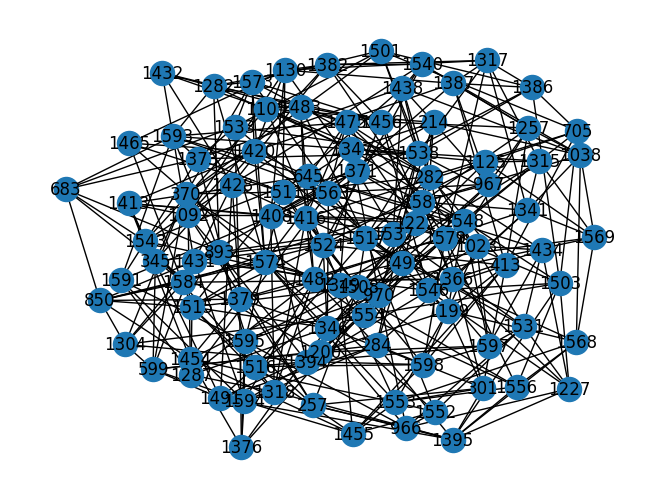

In [1439]:
def contract_edge(graph, u, v):
    """
    Contract edge (u, v) by merging node v into node u
    """
    for neighbor in list(graph.neighbors(v)):
        if neighbor != u:
            if graph.has_edge(u, neighbor):
                graph[u][neighbor]['weight'] += graph[v][neighbor]['weight']
            else:
                graph.add_edge(u, neighbor, weight=graph[v][neighbor]['weight'])
    
    graph.remove_node(v)
def contraction_partitioning(graph, max_size):
    """
    Simple contraction-based graph partitioning
    """

    # Starting by find a matching using edge colours

    new_graph = graph.copy()
    for node in new_graph.nodes():
        new_graph.nodes[node]['contained_nodes'] = {node}
    while True:
        matching = nx.max_weight_matching(new_graph, maxcardinality=True, weight='weight')
        contractions = set()
        for match in matching:
            u, v = match
            if len(new_graph.nodes[u]['contained_nodes']) + len(new_graph.nodes[v]['contained_nodes']) <= max_size:
                new_graph.nodes[u]['contained_nodes'].update(new_graph.nodes[v]['contained_nodes'])
            else:
                continue
            contractions.add((u, v))
            new_graph = nx.contracted_edge(new_graph, (u, v), self_loops=False)

        if not contractions:
            break

    return new_graph


new_graph = contraction_partitioning(test_graph, 16)

nx.draw(new_graph, with_labels=True)

print(f'Number of edges in contracted graph: {len(new_graph.edges())}')

for node in new_graph.nodes():
    print(f'Node {node} contains original nodes: {new_graph.nodes[node].get("contained_nodes", {node})}')

In [1440]:
assignment_match = np.zeros(len(test_graph.nodes()), dtype=int)

for i, node in enumerate(new_graph.nodes()):
    for contained_node in list(new_graph.nodes[node]['contained_nodes']):
        assignment_match[contained_node] = i

cut = calculate_cut_size(test_graph, assignment_match)
print(f"Cut size after contraction partitioning: {cut}")

Cut size after contraction partitioning: 811


In [1441]:


qpu_size = (16,)

def find_max_size(graph):
    """Find the maximum partition size based on the graph size"""
    # For simplicity, we set max_size to the number of nodes in the graph
    return len(graph.nodes) + int((3/2)*len(graph.edges))

max_size = find_max_size(test_graph)

print(max_size)

num_partitions = max_size // (qpu_size[0])

print(num_partitions)

qpu_sizes = { i : qpu_size[0] for i in range(num_partitions) }



print("QPU sizes:", qpu_sizes)


5200
325
QPU sizes: {0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16, 11: 16, 12: 16, 13: 16, 14: 16, 15: 16, 16: 16, 17: 16, 18: 16, 19: 16, 20: 16, 21: 16, 22: 16, 23: 16, 24: 16, 25: 16, 26: 16, 27: 16, 28: 16, 29: 16, 30: 16, 31: 16, 32: 16, 33: 16, 34: 16, 35: 16, 36: 16, 37: 16, 38: 16, 39: 16, 40: 16, 41: 16, 42: 16, 43: 16, 44: 16, 45: 16, 46: 16, 47: 16, 48: 16, 49: 16, 50: 16, 51: 16, 52: 16, 53: 16, 54: 16, 55: 16, 56: 16, 57: 16, 58: 16, 59: 16, 60: 16, 61: 16, 62: 16, 63: 16, 64: 16, 65: 16, 66: 16, 67: 16, 68: 16, 69: 16, 70: 16, 71: 16, 72: 16, 73: 16, 74: 16, 75: 16, 76: 16, 77: 16, 78: 16, 79: 16, 80: 16, 81: 16, 82: 16, 83: 16, 84: 16, 85: 16, 86: 16, 87: 16, 88: 16, 89: 16, 90: 16, 91: 16, 92: 16, 93: 16, 94: 16, 95: 16, 96: 16, 97: 16, 98: 16, 99: 16, 100: 16, 101: 16, 102: 16, 103: 16, 104: 16, 105: 16, 106: 16, 107: 16, 108: 16, 109: 16, 110: 16, 111: 16, 112: 16, 113: 16, 114: 16, 115: 16, 116: 16, 117: 16, 118: 16, 119: 16, 120: 16, 

In [1442]:
def set_assignment_from_communities(graph, communities):
    assignment = [0] * len(graph.nodes())
    for i, comm in enumerate(communities):
        for node in comm:
            assignment[node] = i
    return assignment

def set_initial_assignment(graph, num_parts):
    assignment = [0] * len(graph.nodes())
    for i, node in enumerate(graph.nodes()):
        assignment[node] = i % num_parts
    return assignment

def calculate_cut_from_communities(graph, communities):
    cut = 0
    counted_edges = set()
    for comm in communities:
        for node in comm:
            for neighbor in graph.neighbors(node):
                if neighbor not in comm:
                    edge = (min(node, neighbor), max(node, neighbor))
                    if edge not in counted_edges:
                        counted_edges.add(edge)
                        cut += 1
    return cut

def calculate_cut_from_assignment(graph, assignment):
    cut = 0
    for edge in graph.edges():
        node, neighbor = edge
        if assignment[node] != assignment[neighbor]:
            cut += 1
    return cut

def add_unit_weights_to_graph(graph):
    for edge in graph.edges():
        graph.edges[edge]["weight"] = 1
    return graph

def find_num_partitions(graph, qpu_sizes):
    """Find the maximum partition size based on the graph size"""
    # For simplicity, we set max_size to the number of nodes in the graph
    max_size = len(graph.nodes) + 2*len(graph.edges)
    num_partitions = max_size // (qpu_sizes[0])
    return num_partitions

In [1443]:
import networkx as nx
from networkx.algorithms import community
import numpy as np

import copy

def apply_non_uniform_noise(G,noise:float = 5e-4 ,bell_noise:float = 5e-3):
    G = copy.deepcopy(G)
    for u,v in G.edges():
        if G.nodes[u]['QPU'] == G.nodes[v]['QPU']:
            G[u][v]['p'] = noise
        else:
            G[u][v]['p'] = bell_noise
    return G

def cut_nx_graph_max(
    G, qpu_max: int = 25, comms=None, return_comms=False, func="spectral",
    seed=None
):
    ### Inputs
    # - G nx.Graph to partition
    # - QPU_max - max number of vertex in subgraph set
    # - Comms - list of subgraphs as initial inputs (these can be further partions)
    # - return_comms - return the resulting subgraphs selected
    # - seed - random seed for spectral bisection
    # This function does not attempt to find an optimal cut
    # Just bisect the (sub)graphs until there are n segments
    # Spectral - use spectral bisection (eigenvalue partitioning)
    # Kernigham_lin  = min-weight random bisection
    #  spectral seems better but non-optimal
    G = copy.deepcopy(G)
    if func not in ["spectral", "kernighan_lin", "mitis"]:
        raise ValueError("invalid func flag")
    if comms is None:
        comms = [G]
    communities = sorted(
        comms, key=lambda x: len(x.nodes), reverse=True
    )

    if len(G.nodes) <= qpu_max or len(G.nodes) == 1:
        pass  # already done
    elif qpu_max < len(G.nodes) and len(G.nodes) >= 2:
        while len(communities[0].nodes) > 1 and not np.all(
            [len(k.nodes) <= qpu_max for k in communities]
        ):  # keep going while size of communites (|C|) --> n_qpu>=|C|>1
            k_prime = communities.pop(0)
            if func == "spectral":
                left, right = nx.spectral_bisection(k_prime, seed=seed)
            elif func == "kernighan_lin":
                left, right = community.kernighan_lin.kernighan_lin_bisection(
                    k_prime, max_iter=1_000_000
                )
            elif func == "mitis":
                raise NotImplementedError("not done yet sorry")

            communities.append(G.subgraph(left))
            communities.append(G.subgraph(right))
            communities = sorted(
                communities, key=lambda x: len(x.nodes), reverse=True
            )  # set with most nodes - bit of a heuristic choice imo

    else:
        raise ValueError(
            f"can not cut a {len(G.nodes)}-node graph into {qpu_max}-sized segments"
        )
    for device_i, comm in enumerate(communities):
        for node in comm:
            G.nodes[node]["QPU"] = device_i
            # Node is part of device i for devices in range 0..n
    return G, communities


Gqpu, comms = cut_nx_graph_max(
    test_graph, qpu_max=int(16), return_comms=True, func="spectral"
)
spectral_assignment = set_assignment_from_communities(Gqpu, comms)
spectral_cut = calculate_cut_from_assignment(test_graph, spectral_assignment)

print("Spectral cut:", spectral_cut)

qpu_sizes = { i : int(16) for i in range(len(partition_counts)+3) }

print("QPU sizes:", qpu_sizes)

for i, comm in enumerate(comms):
    print(f"Community {i}: {len(comm.nodes)} nodes")


Spectral cut: 788
QPU sizes: {0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16, 11: 16, 12: 16, 13: 16, 14: 16, 15: 16, 16: 16, 17: 16, 18: 16, 19: 16, 20: 16, 21: 16, 22: 16, 23: 16, 24: 16, 25: 16, 26: 16, 27: 16, 28: 16, 29: 16, 30: 16, 31: 16, 32: 16, 33: 16, 34: 16, 35: 16, 36: 16, 37: 16, 38: 16, 39: 16, 40: 16, 41: 16, 42: 16, 43: 16, 44: 16, 45: 16, 46: 16, 47: 16, 48: 16, 49: 16, 50: 16, 51: 16, 52: 16, 53: 16, 54: 16, 55: 16, 56: 16, 57: 16, 58: 16, 59: 16, 60: 16, 61: 16, 62: 16, 63: 16, 64: 16, 65: 16, 66: 16, 67: 16, 68: 16, 69: 16, 70: 16, 71: 16, 72: 16, 73: 16, 74: 16, 75: 16, 76: 16, 77: 16, 78: 16, 79: 16, 80: 16, 81: 16, 82: 16, 83: 16, 84: 16, 85: 16, 86: 16, 87: 16, 88: 16, 89: 16, 90: 16, 91: 16, 92: 16, 93: 16, 94: 16, 95: 16, 96: 16, 97: 16, 98: 16, 99: 16, 100: 16, 101: 16, 102: 16}
Community 0: 16 nodes
Community 1: 16 nodes
Community 2: 16 nodes
Community 3: 16 nodes
Community 4: 16 nodes
Community 5: 16 nodes
Community 6: 16 nodes

In [1444]:
# Test regular FM
import time
from disqco.parti.FM.FM_main_nx import fm_algorithm


fm_assignment, fm_cut, fm_cuts_history = fm_algorithm(test_graph, qpu_sizes, max_iterations=5, move_limit=len(test_graph.nodes()),global_assignment=assignment_match, ancilla=False)
print("\n" + "=" * 60)
print("REGULAR FM RESULTS")
print("=" * 60)
print(f"FM cut size: {fm_cut}")
print(f"Partition sizes: {np.bincount(fm_assignment)}")

# target_partitions = len(qpu_sizes)
# start = time.time()

# recursive_assignment, recursive_cut, recursive_subgraphs = recursive_fm_algorithm(
#     test_graph, target_partitions, max_iterations=5, move_limit=len(test_graph.nodes()))

# end = time.time()

# print(f"Recursive FM Algorithm completed in {end - start:.2f} seconds.")
# print("FINAL RESULTS:")
# print(f"Final cut size: {recursive_cut}")



Spaces: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 16, 101: 16, 102: 16}
Spaces: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 1, 34: 0, 35: 0, 36: 1, 37: 0, 38: 0, 39

In [1445]:
def calculate_capacities(assignment, graph, ancilla=False):
    capacities = {}
    for part in assignment:
        if part not in capacities:
            capacities[part] = 0
        capacities[part] += 1
    if ancilla:
        for edge in graph.edges():
            u, v = edge
            if assignment[u] != assignment[v]:
                capacities[assignment[u]] += 1
                capacities[assignment[v]] += 1
            else:
                capacities[assignment[u]] += 1  # No increase for internal edges
    return capacities



draw_partitioned_graph(test_graph, num_partitions, fm_assignment, f"FM Algorithm (Cut: {fm_cut})")

capacities_final = calculate_capacities(fm_assignment, test_graph, ancilla=True)

print("Capacities after FM with ancillae:", capacities_final)


    



Graph too large to visualize effectively (1600 nodes). Skipping visualization.
Capacities after FM with ancillae: {np.int64(7): 47, np.int64(25): 49, np.int64(4): 48, np.int64(1): 46, np.int64(9): 47, np.int64(20): 47, np.int64(2): 47, np.int64(3): 46, np.int64(0): 47, np.int64(57): 48, np.int64(51): 48, np.int64(99): 46, np.int64(31): 47, np.int64(87): 47, np.int64(37): 45, np.int64(41): 47, np.int64(16): 46, np.int64(79): 44, np.int64(46): 48, np.int64(55): 47, np.int64(11): 48, np.int64(76): 48, np.int64(6): 47, np.int64(22): 45, np.int64(15): 46, np.int64(8): 47, np.int64(101): 25, np.int64(65): 44, np.int64(60): 47, np.int64(70): 46, np.int64(54): 47, np.int64(67): 48, np.int64(89): 43, np.int64(47): 44, np.int64(45): 44, np.int64(81): 48, np.int64(97): 41, np.int64(73): 45, np.int64(17): 47, np.int64(49): 45, np.int64(75): 44, np.int64(85): 46, np.int64(21): 45, np.int64(69): 47, np.int64(44): 47, np.int64(84): 46, np.int64(62): 47, np.int64(24): 48, np.int64(50): 43, np.int64(13

In [1446]:
# Compare with nx spectral bisecction and Kernighan-Lin
import copy
from networkx.algorithms import community

def cut_nx_graph_max(
    G, qpu_max: int = 25, comms=None, return_comms=False, func="spectral",
    seed=None
):
    ### Inputs
    # - G nx.Graph to partition
    # - QPU_max - max number of vertex in subgraph set
    # - Comms - list of subgraphs as initial inputs (these can be further partions)
    # - return_comms - return the resulting subgraphs selected
    # - seed - random seed for spectral bisection
    # This function does not attempt to find an optimal cut
    # Just bisect the (sub)graphs until there are n segments
    # Spectral - use spectral bisection (eigenvalue partitioning)
    # Kernigham_lin  = min-weight random bisection
    #  spectral seems better but non-optimal
    G = copy.deepcopy(G)
    if func not in ["spectral", "kernighan_lin", "mitis"]:
        raise ValueError("invalid func flag")
    if comms is None:
        comms = [G]
    communities = sorted(
        comms, key=lambda x: len(x.nodes), reverse=True
    )

    if len(G.nodes) <= qpu_max or len(G.nodes) == 1:
        pass  # already done
    elif qpu_max < len(G.nodes) and len(G.nodes) >= 2:
        while len(communities[0].nodes) > 1 and not np.all(
            [len(k.nodes) <= qpu_max for k in communities]
        ):  # keep going while size of communites (|C|) --> n_qpu>=|C|>1
            k_prime = communities.pop(0)
            if func == "spectral":
                left, right = nx.spectral_bisection(k_prime, seed=seed)
            elif func == "kernighan_lin":
                left, right = community.kernighan_lin.kernighan_lin_bisection(
                    k_prime, max_iter=1_000_000
                )
            elif func == "mitis":
                raise NotImplementedError("not done yet sorry")

            communities.append(G.subgraph(left))
            communities.append(G.subgraph(right))
            communities = sorted(
                communities, key=lambda x: len(x.nodes), reverse=True
            )  # set with most nodes - bit of a heuristic choice imo

    else:
        raise ValueError(
            f"can not cut a {len(G.nodes)}-node graph into {qpu_max}-sized segments"
        )
    for device_i, comm in enumerate(communities):
        for node in comm:
            G.nodes[node]["QPU"] = device_i
            # Node is part of device i for devices in range 0..n
    return G, communities


In [1447]:
start = time.time()
G, comms = cut_nx_graph_max(test_graph, qpu_max=max(list(qpu_sizes.values())), func="kernighan_lin")
end = time.time()
print(f"Graph partitioning completed in {end - start:.2f} seconds.")

Graph partitioning completed in 0.27 seconds.


In [1448]:


assignment_KL = set_assignment_from_communities(test_graph, comms)

partition_counts = [len([n for n in assignment_KL if n == i]) for i in range(max(assignment_KL) + 1)]
print(f"\nPartition sizes from NetworkX KL: {partition_counts}")
draw_partitioned_graph(test_graph, max(assignment_KL)+1, assignment_KL, "Final Partition (After NetworkX Kernighan-Lin)")

cut_KL = calculate_cut_from_assignment(test_graph, assignment_KL)
print(f"Cut size from NetworkX KL: {cut_KL}")



Partition sizes from NetworkX KL: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
Graph too large to visualize effectively (1600 nodes). Skipping visualization.
Cut size from NetworkX KL: 907


In [1449]:
from disqco.parti.fgp.fgp_roee import (
    run_initial_OEE
)
from disqco.parti.FM.FM_methods_nx import set_initial_partition_assignment
assignment = set_initial_partition_assignment(test_graph, list(qpu_sizes.values()), method='greedy')
start_time = time.time()
refined_assignment, mapping = run_initial_OEE(test_graph, assignment, list(qpu_sizes.values()))

print('Cut from OEE:', calculate_cut_from_assignment(test_graph, refined_assignment))
print(f'Time taken: {time.time() - start_time:.2f} seconds')

partition_counts = [len([n for n in refined_assignment if n == i]) for i in range(num_partitions)]

print(f"\nPartition sizes from OEE: {partition_counts}")


Running OEE


KeyboardInterrupt: 

[0 1 0 0 1 1 0 1 0 0 2 1 1 2 6 4 0 0 2 1 0 4 2 4 1 2 2 1 1 2 6 5 3 3 2 5 4
 3 4 5 3 0 4 2 4 4 4 2 5 3 3 3 5 5 6 5 4 3 3 5 5 6 3 5]


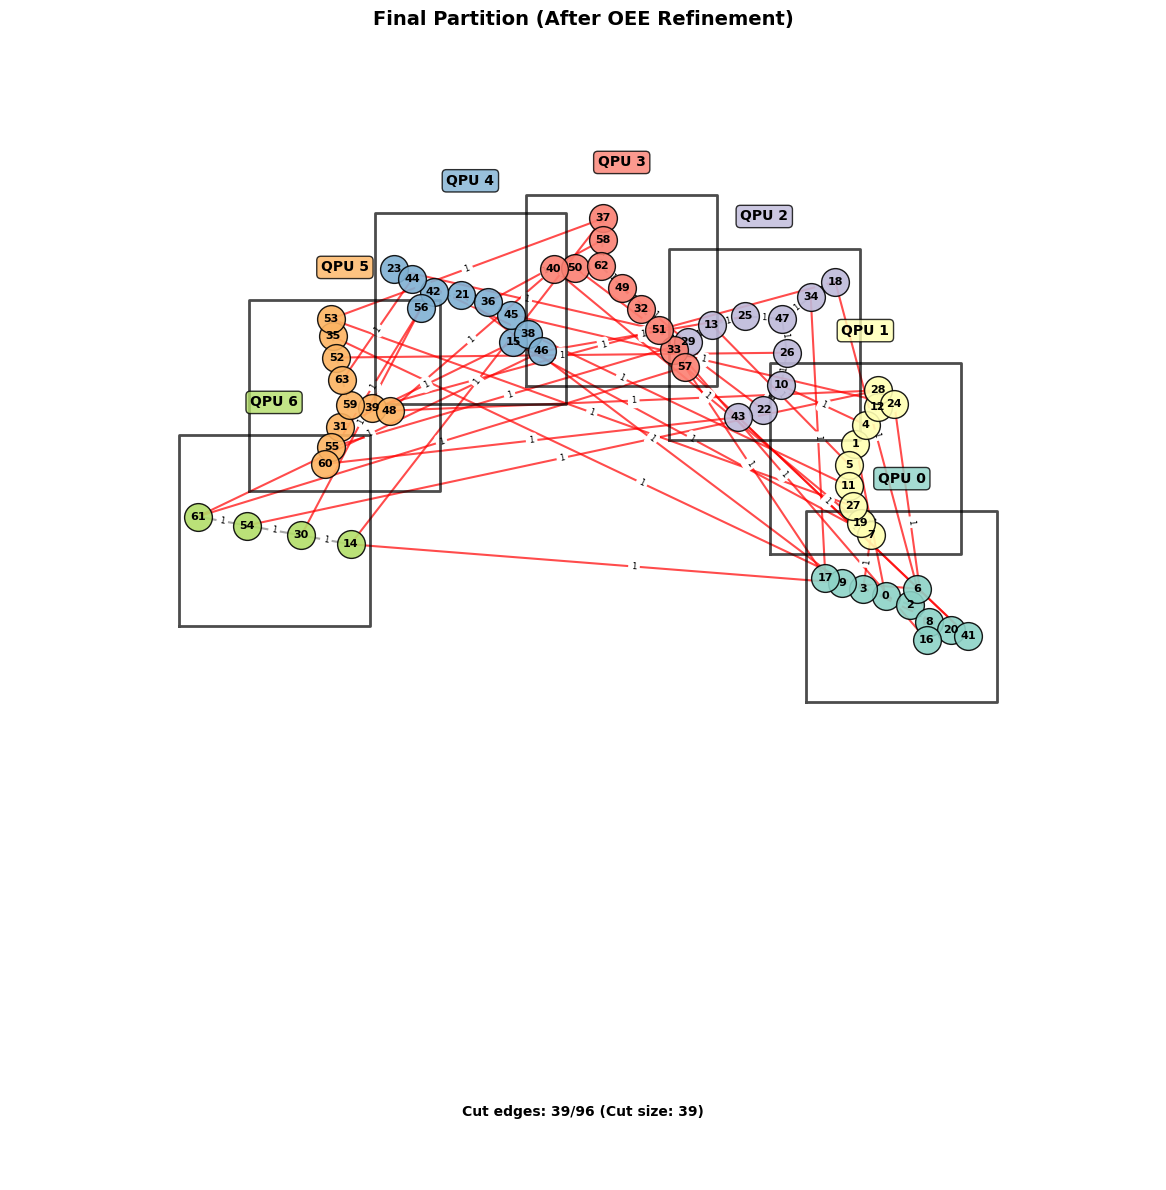

In [ ]:
print(refined_assignment)

draw_partitioned_graph(test_graph, num_partitions, refined_assignment, "Final Partition (After OEE Refinement)")

Graph partitioning completed in 0.16 seconds.
Spectral cut: 40


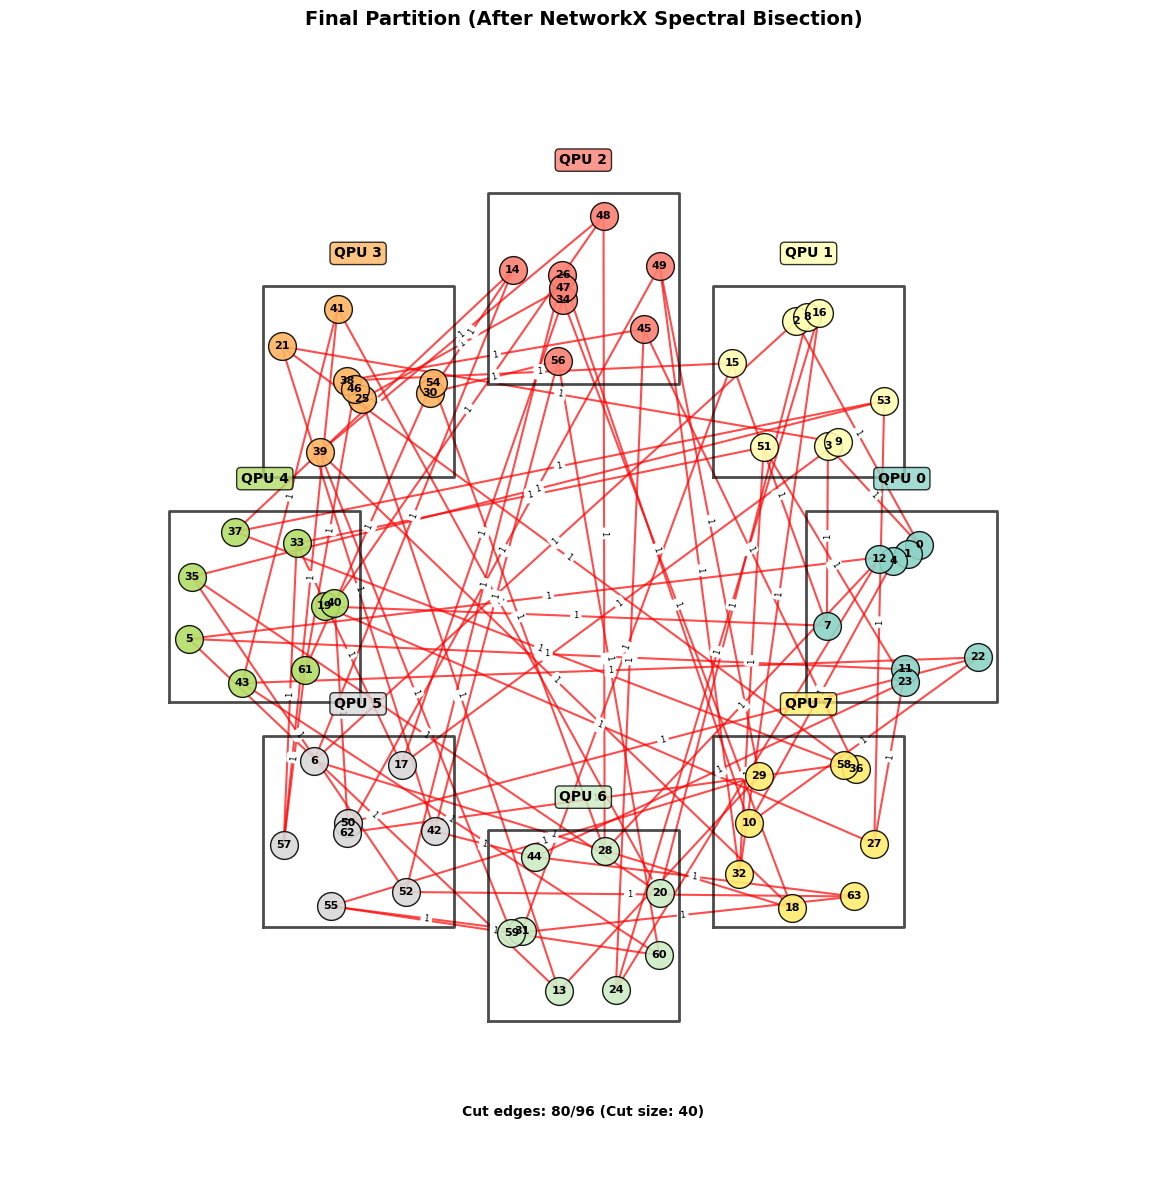

In [ ]:
start = time.time()
G, comms = cut_nx_graph_max(test_graph, qpu_max=max(list(qpu_sizes.values())), func="spectral", seed=42)
end = time.time()
print(f"Graph partitioning completed in {end - start:.2f} seconds.")

assignment_SB = set_assignment_from_communities(test_graph, comms)
spectral_cut = calculate_cut_from_assignment(test_graph, assignment_SB)

print("Spectral cut:", spectral_cut)

draw_partitioned_graph(test_graph, max(assignment_SB)+1, assignment_SB, "Final Partition (After NetworkX Spectral Bisection)")


In [ ]:
cut_SB = calculate_cut_from_assignment(test_graph, assignment_SB)
print(f"\nCut size from NetworkX spectral bisection: {cut_SB}")


Cut size from NetworkX spectral bisection: 40
